In [ ]:
"""
Diego Armando Sarmiento Ahumada
301379640
Unsupervised Learning - Section 001
"""

In [1]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import seaborn as sns
from scipy.ndimage import rotate

 1.	Retrieve and load the Olivetti faces dataset

In [2]:
olivetti_faces = datasets.fetch_olivetti_faces()

In [3]:
X = olivetti_faces.data
y = olivetti_faces.target

2.	Split the dataset into training, validation, and test sets using stratified sampling to ensure that each set contains the same number of images per person

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=40)

# Print the sizes of the splits to verify
print(f"Training set: {X_train.shape[0]}")
print(f"Validation set: {X_validation.shape[0]}")
print(f"Test set: {X_test.shape[0]}")

Training set: 320
Validation set: 40
Test set: 40


3.	Apply PCA on the training data, preserving 99% of the variance, to reduce the dataset’s dimensionality

In [5]:
# Apply PCA to the training set

pca = PCA(n_components=0.99, random_state=40)
X_train_pca = pca.fit_transform(X_train)
X_validation_pca = pca.transform(X_validation)
X_test_pca = pca.transform(X_test)

print(f"Number of components: {pca.n_components_}")

Number of components: 221


4.	Determine the most suitable covariance type for the dataset

In [7]:
gmm_full = GaussianMixture(n_components=40, covariance_type='full', random_state=40, n_init=5)
gmm_full.fit(X_train_pca)
bic_scores_full = gmm_full.bic(X_validation_pca)
print(f"full score: {bic_scores_full}")

best_cov_type = np.argmin(bic_scores_full)

full score: 566379288.7132856


In [8]:
gmm_tied = GaussianMixture(n_components=40, covariance_type='tied', random_state=40, n_init=5)
gmm_tied.fit(X_train_pca)
bic_scores_tied = gmm_tied.bic(X_validation_pca)
print(f"Tied score: {bic_scores_tied}")

best_cov_type = np.argmin(bic_scores_tied)

Tied score: 136518.46825573975


In [9]:
gmm_diag = GaussianMixture(n_components=40, covariance_type='diag', random_state=40, n_init=5)
gmm_diag.fit(X_train_pca)
bic_scores_diag = gmm_diag.bic(X_validation_pca)
print(f"diag score: {bic_scores_diag}")

best_cov_type = np.argmin(bic_scores_diag)

diag score: 65876.15180526422


In [11]:
gmm_spherical = GaussianMixture(n_components=40, covariance_type='spherical', random_state=40, n_init=5)
gmm_spherical.fit(X_train_pca)
bic_scores_spherical = gmm_spherical.bic(X_validation_pca)
print(f"spherical score: {bic_scores_spherical}")

best_cov_type = np.argmin(bic_scores_spherical)

spherical score: 41119.655870095194


5.	Determine the minimum number of clusters that best represent the dataset using either AIC or BIC

In [7]:
n_components_range = range(20, 61, 5)
bic_scores_range = []

for n in n_components_range:
    gmm = GaussianMixture(
        n_components=n,
        covariance_type='spherical',
        random_state=42,
        n_init=5
    )
    gmm.fit(X_train_pca)
    bic_scores_range.append(gmm.bic(X_validation_pca))

optimal_n_components = n_components_range[np.argmin(bic_scores_range)]
print(f"Optimal number of clusters: {optimal_n_components}")

Optimal number of clusters: 20


In [8]:
# Train model with optimal parameters

final_gmm = GaussianMixture(
    n_components=optimal_n_components,
    covariance_type='spherical',
    random_state=40,
    n_init=5
)
final_gmm.fit(X_train_pca)

GaussianMixture(covariance_type='spherical', n_components=20, n_init=5,
                random_state=40)

6.	Plot the results from steps 3 and 4

Text(0.5, 1.0, 'PCA Explained Variance')

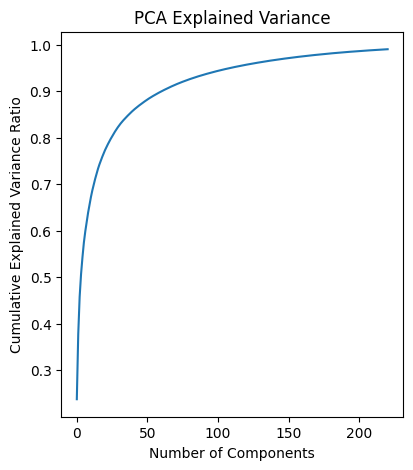

In [13]:
plt.figure(figsize=(15, 5))

# Plot 1: Explained variance ratio
plt.subplot(131)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance')

Text(0.5, 1.0, 'Covariance Type Comparison')

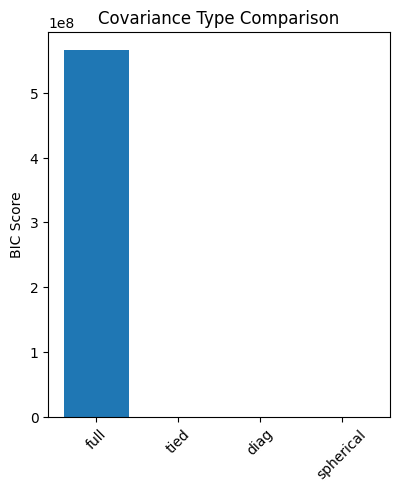

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(132)
plt.bar(covariance_types, bic_scores)
plt.xticks(rotation=45)
plt.ylabel('BIC Score')
plt.title('Covariance Type Comparison')

Text(0.5, 1.0, 'Optimal Number of Clusters')

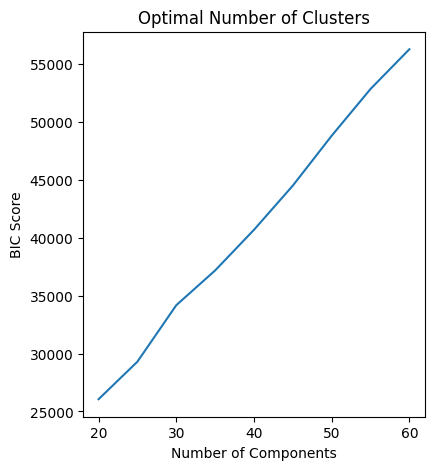

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(133)
plt.plot(n_components_range, bic_scores_range)
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('Optimal Number of Clusters')

7.	Output the hard clustering assignments for each instance to identify which cluster each image belongs to

In [17]:
hard_clusters = final_gmm.predict(X_test_pca)
print("\nHard clustering:")
print(hard_clusters[:10])


Hard clustering:
[ 5 12 10  8  3  9 11  4  2 10]


8.	Output the soft clustering probabilities for each instance to show the likelihood of each image belonging to each cluster

In [18]:
soft_clusters = final_gmm.predict_proba(X_test_pca)
print("\nSoft clustering:")
print(soft_clusters[0, :5])


Soft clustering:
[1.18540542e-165 0.00000000e+000 2.67594158e-070 6.13757206e-033
 9.06167360e-241]


9.	Use the model to generate some new faces (using the sample() method) and visualize them (use the inverse_transform() method to transform the data back to its original space based on the PCA method used)

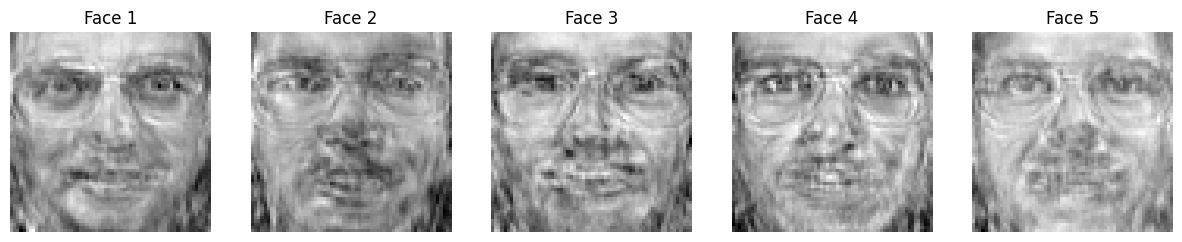

In [16]:
n_samples = 5
generated_samples = final_gmm.sample(n_samples)[0]
reconstructed_faces = pca.inverse_transform(generated_samples)

plt.figure(figsize=(15, 3))
for i in range(n_samples):
    plt.subplot(1, n_samples, i + 1)
    plt.imshow(reconstructed_faces[i].reshape(64, 64), cmap='gray')
    plt.axis('off')
    plt.title(f'Face {i+1}')
plt.show()

10.	Modify some images (e.g., rotate, flip, darken).

In [ ]:
modified_images = []
modification_types = []
    
# Select random images
indices = np.random.choice(len(X_test), 5, replace=False)
original_images = X_test[indices]

for img in original_images:
    img_64 = img.reshape(64, 64)

    # 1. Rotate
    rotated = rotate(img_64, angle=45, reshape=False).flatten()
    modified_images.append(rotated)
    modification_types.append('Rotated 45°')

    # 2. Flip
    flipped_h = np.fliplr(img_64).flatten()
    modified_images.append(flipped_h)
    modification_types.append('Flipped Horizontal')
        
    # 3. Darken
    darkened = (img_64 * 0.5).flatten()
    modified_images.append(darkened)
    modification_types.append('Darkened')

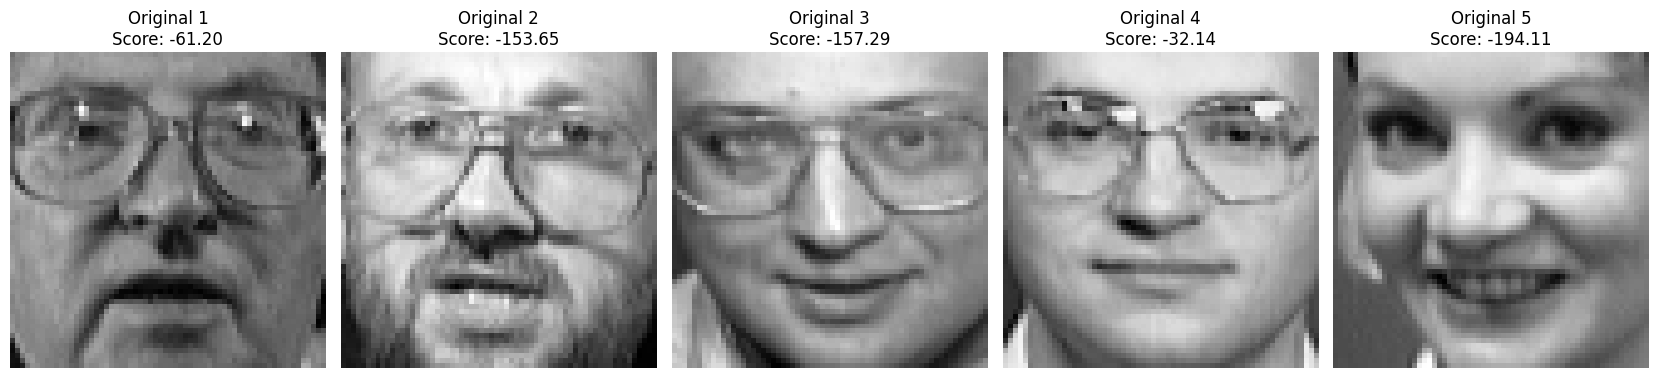

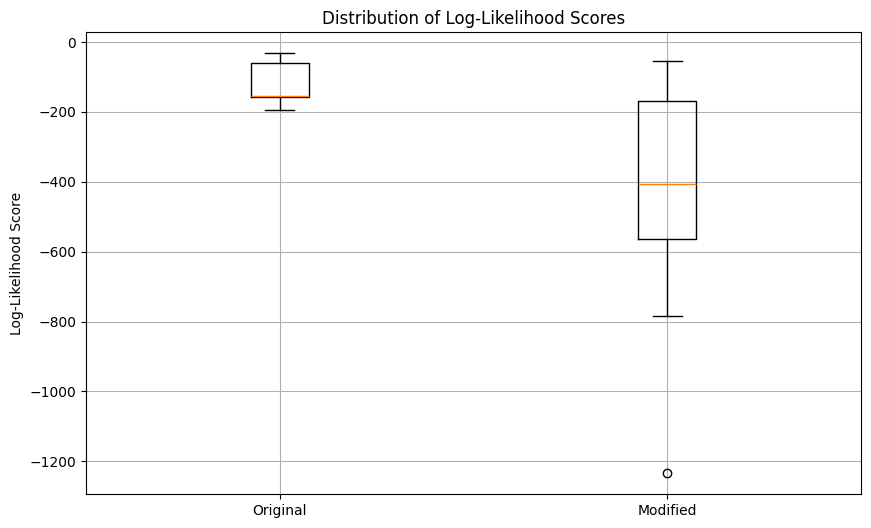


Score Statistics:
Original Images - Mean: -119.68, Std: 61.96
Modified Images - Mean: -402.77, Std: 270.64

Anomaly Detection Analysis:
Rotated 45°: Score difference = -503.75
Flipped Horizontal: Score difference = -215.00
Darkened: Score difference = -721.79
Brightened: Score difference = -270.27
Noisy: Score difference = -17.69
Rotated 45°: Score difference = -461.36
Flipped Horizontal: Score difference = -16.62
Darkened: Score difference = -269.80
Brightened: Score difference = -415.48
Noisy: Score difference = -19.16
Rotated 45°: Score difference = -380.76
Flipped Horizontal: Score difference = 1.43
Darkened: Score difference = -384.89
Brightened: Score difference = -324.21
Noisy: Score difference = -8.31
Rotated 45°: Score difference = -646.91
Flipped Horizontal: Score difference = -104.13
Darkened: Score difference = -108.75
Brightened: Score difference = -1202.35
Noisy: Score difference = -23.20
Rotated 45°: Score difference = -432.79
Flipped Horizontal: Score difference = 24.5

In [ ]:
# Create modifications 

def create_modified_images(images, n_samples=5):
    modified_images = []
    modification_types = []
    
    # Select random images
    indices = np.random.choice(len(images), n_samples, replace=False)
    original_images = images[indices]
    
    for img in original_images:
        img_64 = img.reshape(64, 64)
        
        # Create different modifications
        # 1. Rotate
        rotated = rotate(img_64, angle=45, reshape=False).flatten()
        modified_images.append(rotated)
        modification_types.append('Rotated 45°')
        
        # 2. Flip horizontal
        flipped_h = np.fliplr(img_64).flatten()
        modified_images.append(flipped_h)
        modification_types.append('Flipped Horizontal')
        
        # 3. Darken
        darkened = (img_64 * 0.5).flatten()
        modified_images.append(darkened)
        modification_types.append('Darkened')
        
        # 4. Brighten
        brightened = np.minimum(img_64 * 1.5, 1.0).flatten()
        modified_images.append(brightened)
        modification_types.append('Brightened')
        
        # 5. Add noise
        noisy = img_64 + np.random.normal(0, 0.1, img_64.shape)
        noisy = np.clip(noisy, 0, 1).flatten()
        modified_images.append(noisy)
        modification_types.append('Noisy')
    
    return np.array(modified_images), modification_types, original_images

# Create modified images
modified_images, modification_types, original_images = create_modified_images(X_test, n_samples=5)

# 2. Anomaly Detection Analysis
# Transform original and modified images to PCA space
original_pca = pca.transform(original_images)
modified_pca = pca.transform(modified_images)

# Get log-likelihood scores
original_scores = gmm.score_samples(original_pca)
modified_scores = gmm.score_samples(modified_pca)

# Plotting
plt.figure(figsize=(20, 10))

# Plot original vs modified images
n_modifications = len(modification_types) // len(original_images)
for i in range(len(original_images)):
    # Original image
    plt.subplot(2, 6, i + 1)
    plt.imshow(original_images[i].reshape(64, 64), cmap='gray')
    plt.title(f'Original {i+1}\nScore: {original_scores[i]:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Statistical Analysis of Scores
plt.figure(figsize=(10, 6))
plt.boxplot([original_scores, modified_scores], labels=['Original', 'Modified'])
plt.title('Distribution of Log-Likelihood Scores')
plt.ylabel('Log-Likelihood Score')
plt.grid(True)
plt.show()

# Print summary statistics
print("\nScore Statistics:")
print(f"Original Images - Mean: {original_scores.mean():.2f}, Std: {original_scores.std():.2f}")
print(f"Modified Images - Mean: {modified_scores.mean():.2f}, Std: {modified_scores.std():.2f}")

# Calculate anomaly detection metrics
print("\nAnomaly Detection Analysis:")
for i, mod_type in enumerate(modification_types):
    score_diff = modified_scores[i] - original_scores[i // n_modifications]
    print(f"{mod_type}: Score difference = {score_diff:.2f}")